In [ ]:
import matplotlib as mpl
import os
from dotenv import load_dotenv
from smtplib import SMTP
from email.message import EmailMessage
import pandas as pd
from prophet import Prophet

mpl.rcParams['figure.figsize'] = (10,8)
mpl.rcParams['axes.grid'] = False

df1 = pd.read_csv('resources/transactions_1_tmp.csv')
df2 = pd.read_csv('resources/transactions_2_tmp.csv')

In [2]:
df1['time'] = pd.to_datetime(df1['time'], format='%H:%M')
df2['time'] = pd.to_datetime(df2['time'], format='%H:%M')

df1 = df1.loc[(df1['status'] == 'reversed') | (df1['status'] == 'failed') | (df1['status'] == 'denied')]
df2 = df2.loc[(df2['status'] == 'reversed') | (df2['status'] == 'failed') | (df2['status'] == 'denied')]

df3 = pd.concat([df1, df2])

In [ ]:
df3['timestamp'] = pd.to_datetime(df3['timestamp'])
df3 = df3.set_index('timestamp').resample('H').mean()

df3 = df3.reset_index()
df3 = df3[['timestamp', 'count']].rename({'timestamp':'ds', 'count':'y'}, axis='columns')

In [4]:
#test = df3[(df3['ds'] >= '2022-11-01') & (df3['ds'] < '2022-11-02')]
#train = df3[(df3['ds'] >= '2022-11-02')]

In [5]:
#test.shape

In [6]:
#train.shape

In [7]:
m = Prophet(changepoint_range=0.95)

In [8]:
m.fit(df3)

22:21:05 - cmdstanpy - INFO - Chain [1] start processing
22:21:05 - cmdstanpy - INFO - Chain [1] done processing


In [9]:
future = m.make_future_dataframe(periods=48, freq='H')

In [10]:
#future.tail(72)

In [11]:
forecast = m.predict(future)
forecast[['ds','yhat','yhat_lower','yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
91,2022-11-04 19:00:00,18.687654,2.481176,36.695014
92,2022-11-04 20:00:00,18.754321,1.529106,36.561661
93,2022-11-04 21:00:00,18.820987,2.380724,36.002199
94,2022-11-04 22:00:00,18.887654,1.897390,36.382395
95,2022-11-04 23:00:00,18.954320,1.578713,36.349191


In [12]:
results=pd.concat([df3.set_index('ds')['y'],forecast.set_index('ds')[['yhat','yhat_lower','yhat_upper']]],axis=1)

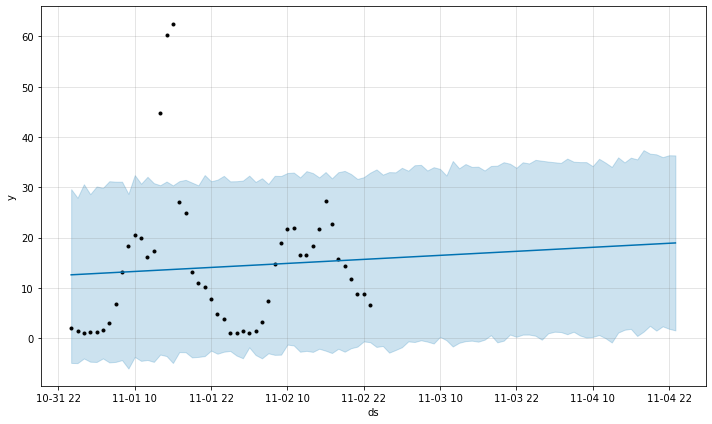

In [14]:
fig1 = m.plot(forecast)

In [ ]:
comp = m.plot_components(forecast)

In [ ]:
results

In [17]:
results['error'] = results['y'] - results['yhat']

In [18]:
results['uncertainty'] = results['yhat_upper'] - results['yhat_lower']

In [ ]:
results

In [20]:
#results[results['error']].abs() > 1.5*results['uncertainty']
#Encountering issue due to NaN 'y's. The data hasn't missing values or unfit indexes

In [ ]:
#Identify annomaly by Confidence Interval 
out_up = df3.loc[df3['y'] > 30, ['ds','y']]
out_up

In [22]:
load_dotenv()
email = os.environ['email_address']
passcode = os.environ['keycode']

def email_alert(subject,body,to):
     msg = EmailMessage()
     msg.set_content(body)
     msg['subject'] = subject
     msg['to'] = to
     msg['from'] = email

     user = email
     password = passcode

     server = SMTP("smtp.gmail.com",587)
     server.starttls()
     server.login(user, password)
     server.send_message(msg)

     server.quit()

msg = 'Please, check these datapoints {}'.format(out_up)
email_alert('[TEST]Anomaly Detection Alert',msg, email)
